In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import fileinput
from pandas_profiling import ProfileReport
import json
import io
import collections
%matplotlib inline

In [2]:
parsed_data = pd.read_csv("output_4_14.csv", sep=",")

In [3]:
len(parsed_data)

1524843

In [4]:
parsed_data.head()

,Unnamed: 0,idx,CWR,ECE,URG,ACK,PSH,RST,SYN,FIN,date_time,SRC
0,0,0,0,0,0,0,0,0,0,0,Apr 07 22:27:58,73.231.179.146
1,1,1,0,0,0,0,0,0,0,0,Apr 07 22:27:59,51.68.32.21
2,2,2,0,0,0,0,0,0,0,0,Apr 07 22:27:59,51.68.32.21
3,3,3,0,0,0,0,0,0,0,0,Apr 07 22:27:59,73.231.179.146
4,4,4,0,0,0,0,0,0,0,0,Apr 07 22:27:59,73.231.179.146


In [5]:
# Get unique count of IP addresses 
df_2 = parsed_data[['SRC', 'date_time']].copy()
df_2.head()
print("There are", len(set(df_2['SRC'])), "unique ip addresses collected in the honeypot")

There are 31138 unique ip addresses collected in the honeypot


# Load Grey Noise Data

31138 unique IP addresses were run through the Grey Noise service to provide background info on IPs 

In [6]:
# Read in grey noise results
#
grey_noise = []
with open('nora-results.txt', 'r',encoding="utf8") as file:
    line = file.readline()
    line = line.replace('}{', '}|{')

    t = line.split('|')
    for e in t:
        if len(e) <=1:
            continue

        d = json.loads(e)
        grey_noise.append(d)
        #print(d)

In [7]:
grey_noise = pd.io.json.json_normalize(grey_noise, errors = 'ignore')
grey_noise.head()                              

,ip,seen,classification,first_seen,last_seen,actor,tags,metadata.country,metadata.country_code,metadata.city,...,metadata.rdns,metadata.asn,metadata.tor,metadata.os,metadata.category,raw_data.scan,raw_data.web.paths,raw_data.web.useragents,raw_data.ja3,error
0,73.231.179.146,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51.68.32.21,True,malicious,2020-03-17,2020-04-22,unknown,"[Generic IoT Brute Force Attempt, Mirai, Telne...",France,FR,Roubaix,...,thundersbakery.ie,AS16276,False,Linux 3.11+,hosting,"[{'port': 23, 'protocol': 'TCP'}, {'port': 528...",[],[],[],NaN
2,149.56.14.86,True,malicious,2019-12-30,2020-04-21,unknown,"[SSH Bruteforcer, SSH Scanner, SSH Worm]",Canada,CA,Montréal,...,86.ip-149-56-14.net,AS16276,False,unknown,hosting,"[{'port': 22, 'protocol': 'TCP'}, {'port': 78,...",[],[],[],NaN
3,167.71.140.81,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,165.22.203.170,True,unknown,2019-07-28,2020-04-08,unknown,"[DNS Scanner, FTP Scanner, Router RPC Scanner,...",Netherlands,NL,Amsterdam,...,mx.spamhaus.org,AS14061,False,Linux 3.x,hosting,"[{'port': 21, 'protocol': 'TCP'}, {'port': 22,...",[],[],[],NaN


In [8]:
print(list(grey_noise.columns))
grey_noise.head()
print(len(grey_noise))

['ip', 'seen', 'classification', 'first_seen', 'last_seen', 'actor', 'tags', 'metadata.country', 'metadata.country_code', 'metadata.city', 'metadata.organization', 'metadata.rdns', 'metadata.asn', 'metadata.tor', 'metadata.os', 'metadata.category', 'raw_data.scan', 'raw_data.web.paths', 'raw_data.web.useragents', 'raw_data.ja3', 'error']
22791


### Port Scanning Analysis EDA
First we determine how many of our parsed port scans of selected IP addresses have been identified as malicous. 

In [9]:
ip_classification = grey_noise['classification'].value_counts()
ip_classification

unknown      4986
malicious    2622
benign        909
Name: classification, dtype: int64

In [10]:
country_ip  =grey_noise['metadata.country'].value_counts()
print(country_ip) 

print('')
print('ASNs in Data:', '\n')
asn = grey_noise['metadata.asn'].value_counts()
print(asn)


United States    2059
Belgium          2051
China            1082
Germany           367
Netherlands       362
                 ... 
Togo                1
Mauritius           1
Armenia             1
El Salvador         1
Jordan              1
Name: metadata.country, Length: 115, dtype: int64

ASNs in Data: 

AS33864     2043
AS14061      693
AS51167      278
AS4134       235
AS7922       215
            ... 
AS10834        1
AS21249        1
AS263848       1
AS24138        1
AS58689        1
Name: metadata.asn, Length: 1310, dtype: int64


In [11]:
# Get country and city data
location = grey_noise[['metadata.city', 'metadata.country']].copy()

#drop non-unique locations 
location_unique = location.drop_duplicates()     

In [12]:
# import master world cities list to get location data
master_loc = pd.read_csv("worldcities.csv")

In [13]:
master_loc.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [14]:
# merge location and master world cities 
new_loc = pd.merge(location_unique, master_loc, how='left', 
                   left_on=['metadata.city','metadata.country'], right_on=['city','country'])
new_loc.describe(include='all') # We will lose some cities because of they are not major cities

#Drop columns: keep only city, state,and lat long
new_loc = new_loc.drop(columns = ['city', 'city_ascii', 'country', 'iso2', 
                                  'iso3', 'admin_name', 'capital', 'population', 'id'], axis =1)
new_loc.head()

#Merge lat long bacl onto grey_noise data

grey_noise_loc = pd.merge(grey_noise, new_loc, how = 'left', left_on=['metadata.city','metadata.country'], right_on=['metadata.city','metadata.country'] )

In [15]:
print(len(new_loc))
print(len(grey_noise))
print(len(grey_noise_loc))

1945
22791
24319


In [16]:
grey_noise_loc.head()

,ip,seen,classification,first_seen,last_seen,actor,tags,metadata.country,metadata.country_code,metadata.city,...,metadata.tor,metadata.os,metadata.category,raw_data.scan,raw_data.web.paths,raw_data.web.useragents,raw_data.ja3,error,lat,lng
0,73.231.179.146,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51.68.32.21,True,malicious,2020-03-17,2020-04-22,unknown,"[Generic IoT Brute Force Attempt, Mirai, Telne...",France,FR,Roubaix,...,False,Linux 3.11+,hosting,"[{'port': 23, 'protocol': 'TCP'}, {'port': 528...",[],[],[],NaN,NaN,NaN
2,149.56.14.86,True,malicious,2019-12-30,2020-04-21,unknown,"[SSH Bruteforcer, SSH Scanner, SSH Worm]",Canada,CA,Montréal,...,False,unknown,hosting,"[{'port': 22, 'protocol': 'TCP'}, {'port': 78,...",[],[],[],NaN,45.50,-73.5833
3,167.71.140.81,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,165.22.203.170,True,unknown,2019-07-28,2020-04-08,unknown,"[DNS Scanner, FTP Scanner, Router RPC Scanner,...",Netherlands,NL,Amsterdam,...,False,Linux 3.x,hosting,"[{'port': 21, 'protocol': 'TCP'}, {'port': 22,...",[],[],[],NaN,52.35,4.9166


### Visualization

What can we learn about this port scanning activity? 

Questions to consider: 
1) Where are the port scans coming from? 
2) How many of these scans are malicious?
3) What operating systems are being use? 
4) Look up interesting RDNS (why is an irish bakery considered malicious?
5) Look up interesting ASNs
6) Map (location and time--need another merge so smaller data set) 

Parsed Data Port Scans: 
1) What does the time distrubution look like? (parsed data) 
2) What ports are being scanned? 

#### Port Scan Origins

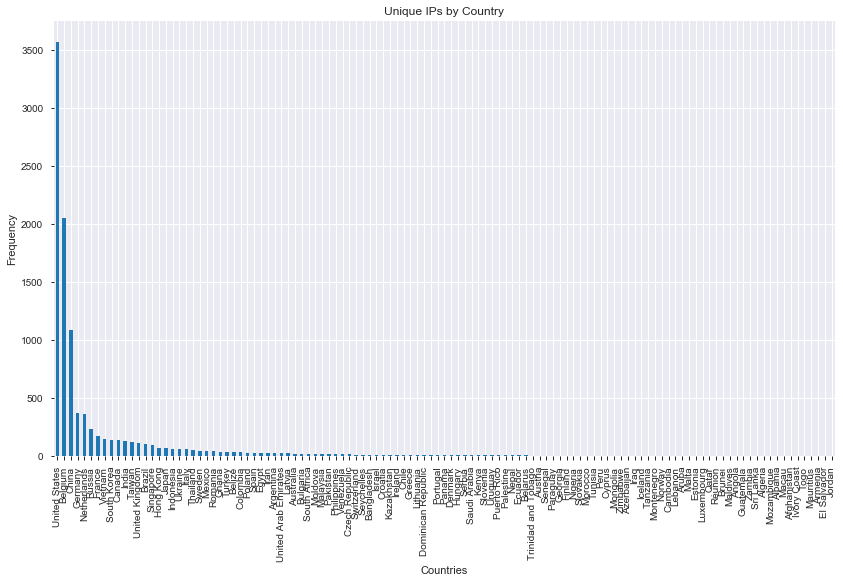

In [17]:
ax = grey_noise_loc['metadata.country'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Unique IPs by Country")
ax.set_xlabel("Countries")
ax.set_ylabel("Frequency")
plt.show()

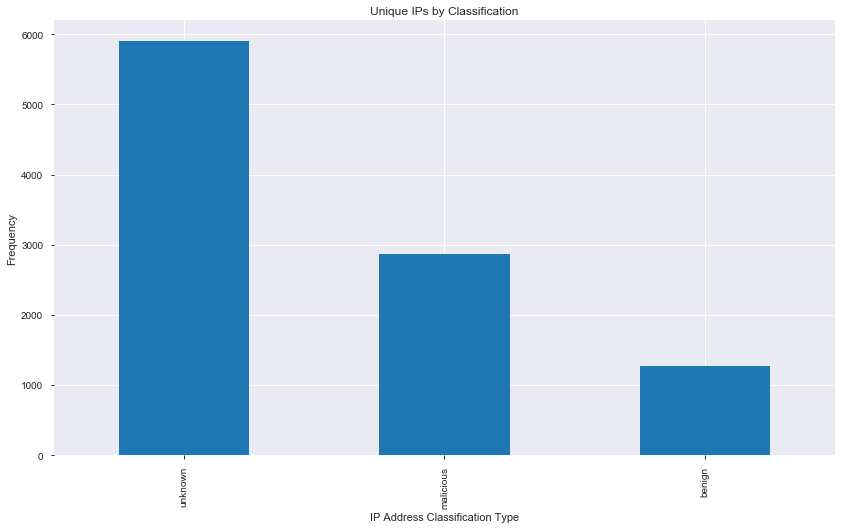

In [18]:
ax = grey_noise_loc['classification'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Unique IPs by Classification")
ax.set_xlabel("IP Address Classification Type")
ax.set_ylabel("Frequency")
plt.show()

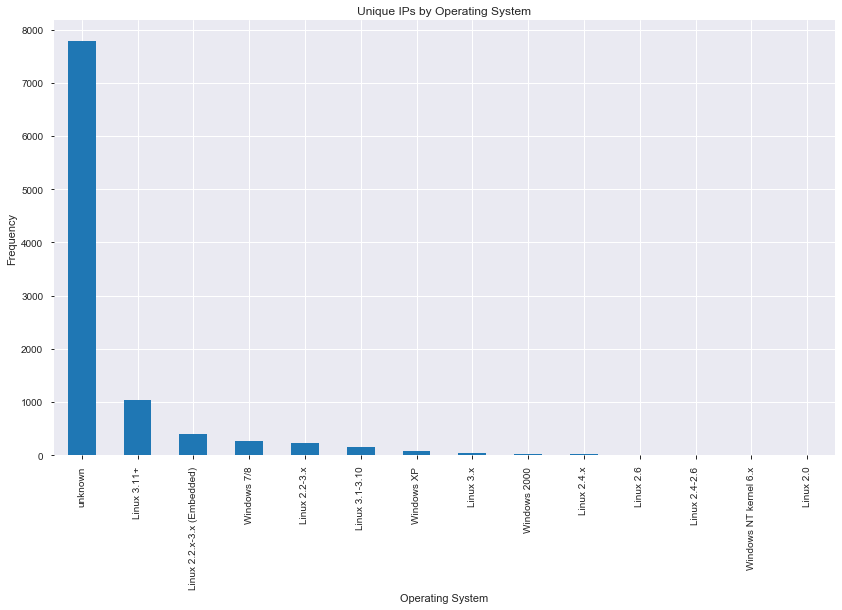

In [19]:
ax = grey_noise_loc['metadata.os'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Unique IPs by Operating System")
ax.set_xlabel("Operating System")
ax.set_ylabel("Frequency")
plt.show()

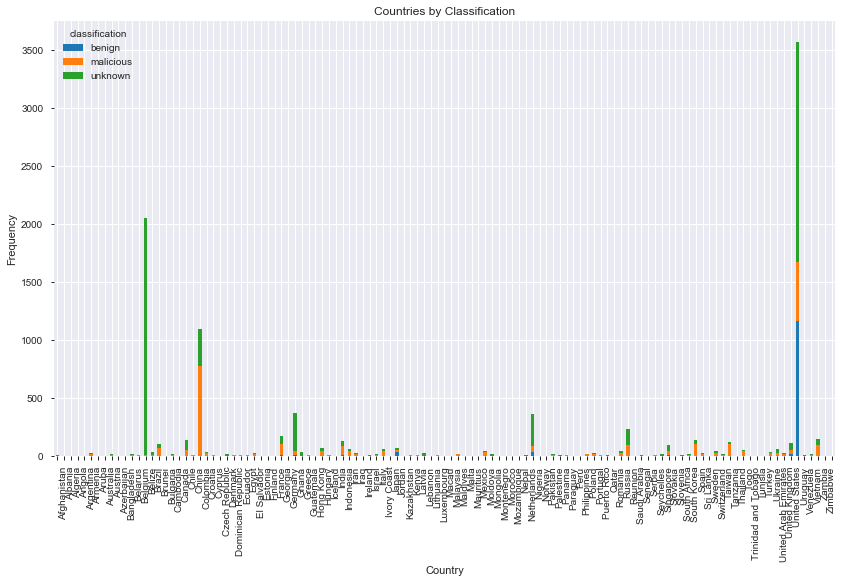

In [79]:
ax = grey_noise_loc.groupby(['metadata.country','classification']).size().unstack().plot(kind='bar',
                                                                                    stacked=True,
                                                                                   figsize=(14,8),
                                                                                   title="Countries by Classification")
ax.set_xlabel("Country")
ax.set_ylabel("Frequency")
# plt.xticks(rotation=280)
plt.show()

In [32]:
# Show names domain names
dns = grey_noise_loc['metadata.rdns']
dns = dns.dropna(axis=0)  # remove NA
dns = list(dict.fromkeys(dns)) # Remove duplicates 

for i in dns:
    print(i)


thundersbakery.ie
86.ip-149-56-14.net
mx.spamhaus.org
ec2-54-93-50-35.eu-central-1.compute.amazonaws.com
zg-0312b-251.stretchoid.com
dynamic-ip-adsl.viettel.vn
xx.freeflux.org
do-prod-eu-west-scanner-0402-8.do.binaryedge.ninja
server-185-153-198-240.cloudedic.net
no-reverse-dns-configured.com
registro.lacnic.net
scan-06n.shadowserver.org
50-198-243-206-static.hfc.comcastbusiness.net
ip-112-58.4vendeta.com
ns570281.ip-51-161-12.net
malware-hunter.census.shodan.io
071-067-158-188.biz.spectrum.com
c-50-134-218-103.hsd1.co.comcast.net
scratch-01.sfj.corp.censys.io
113.72.63.218.broad.lc.yn.dynamic.163data.com.cn
scanner21.openportstats.com
160.ip-192-99-152.net
c-50-158-81-186.hsd1.il.comcast.net
190-79-210-16.dyn.dsl.cantv.net
bba590646.alshamil.net.ae
scan049.intrinsec.com
zg-0312c-103.stretchoid.com
196.52.43.61.netsystemsresearch.com
ec2-34-207-73-231.compute-1.amazonaws.com
zg-0312c-457.stretchoid.com
scan-64.security.ipip.net
scanner151.openportstats.com
static-50-53-105-184.bvtn.or.

zg-0312c-69.stretchoid.com
h238-210-66-115.seed.net.tw
host-186-4-151-103.netlife.ec
92.118.161.49.netsystemsresearch.com
zg-0312c-245.stretchoid.com
122-116-75-124.hinet-ip.hinet.net
c-73-173-150-74.hsd1.md.comcast.net
91.233.46.103-in-addr.arpa-applefiber.net
45.77.253.171.vultr.com
215.217.70.37.rev.sfr.net
mta1.urbanmail.xyz
92.118.161.5.netsystemsresearch.com
zg-0312c-135.stretchoid.com
ip-112-38.4vendeta.com
mtw.ru
106-145-15-204-ce-016.nnpr.net
li1873-236.members.linode.com
net-247-pc250.socialmarketing.net
mail.i-wyman.com
220-132-151-199.hinet-ip.hinet.net
vmi370421.contaboserver.net
h87-236-93-34.cust.a3fiber.se
zg-0312c-339.stretchoid.com
134-249-96-246.broadband.kyivstar.net
do-prod-ap-south-burner-0402-3.do.binaryedge.ninja
ns2.gz.chinamobile.com
c-73-85-110-241.hsd1.fl.comcast.net
zg-0312b-255.stretchoid.com
149.28.84.236.vultr.com
zg-0312c-147.stretchoid.com
45.99.232.180.ids.static.eastern-tele.com
3ddfaa1a.ni.net.tr
bzq-134-220.red.bezeqint.net
196.52.43.129.netsystems

12.cust-d00.waldc.net
196.52.43.56.netsystemsresearch.com
170.cust-c00.waldc.net
42.cust-c00.waldc.net
108.cust-d00.waldc.net
zg-0312c-120.stretchoid.com
zg-0312c-176.stretchoid.com
108.cust-c00.waldc.net
34.cust-c00.waldc.net
180.cust-d00.waldc.net
nsg-static-185.43.76.182-airtel.com
zg-0312b-185.stretchoid.com
217.128-17-84.waldc.net
173.cust-d00.waldc.net
93-57-18-42.ip162.fastwebnet.it
137.128-17-84.waldc.net
229.cust-b32.waldc.net
11.cust-c00.waldc.net
arn1285831.lnk.telstra.net
4.128-17-84.waldc.net
5.128-17-84.waldc.net
vm1745.spectraip.eu
host-186-4-184-228.netlife.ec
zg-0312c-401.stretchoid.com
90.cust-d00.waldc.net
85-192-128-23.dsl.esoo.ru
75.cust-c00.waldc.net
153.cust-b32.waldc.net
ip128.ip-54-36-204.eu
black.host-71.239.142.185.in-addr.arpa
75.cust-d00.waldc.net
host247-147-38-89.static.arubacloud.com
i19-les01-ntr-176-186-77-215.sfr.lns.abo.bbox.fr
2.cust-c00.waldc.net
2.154.237.139.dyn.user.ono.com
fixed-187-189-228-25.totalplay.net
229.128-17-84.waldc.net
34.cust-d00.w

In [22]:
print("There are" ,len(dns), "unique domain names")

There are 4024 unique domain names


In [33]:
# How many of each domain? I expect to see a fair bit of .com, .net, and .be (Belgium)

tld_list = []
for domain in dns: 
    tld = domain.rsplit('.',1)
    tld_end = tld[1]
    tld_list.append(tld_end)

    tld_list

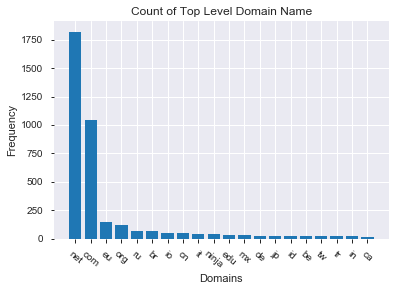

In [24]:
# Get Dict
tld_list_count = collections.Counter(tld_list)
sorted_dict = {k: v for k, v in sorted(tld_list_count.items(), key=lambda item: item[1], reverse=True)}


# PLot
domains = list(sorted_dict.keys())
counts = list(sorted_dict.values())


plt.xlabel('Domains')
plt.ylabel('Frequency')
plt.title("Count of Top Level Domain Name")
plt.xticks(rotation=320)
plt.bar(domains[:20], counts[:20])
plt.show()

As expected, .net and .com are the highest. But this is more .ru than I expected to see and curious what .ninja is. 

### Parse Grey Noise Dataframe  Domain Names
Parse from the dataframe to get a sense of how many do not include  domain name 

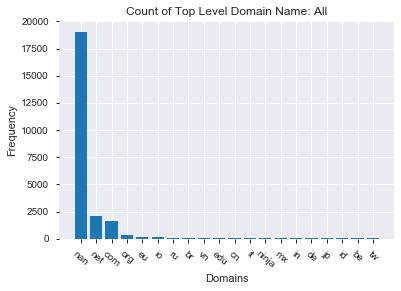

In [71]:
# Show names domain names
domain_end = grey_noise_loc['metadata.rdns']

domains_list =[]
for i in domain_end:
    if type(i) == float: # Can't split on a float
        i = str(i)
        domains_list.append(i)
    else:
        tld = i.rsplit('.', 1)
        tld_end = tld[1]
        domains_list.append(tld_end)
# Give the NaNs some time of value to parse through and split 

# Get Dict
domains_list_count = collections.Counter(domains_list)
sorted_dict_all = {k: v for k, v in sorted(domains_list_count.items(), key=lambda item: item[1], reverse=True)}


# PLot
domains = list(sorted_dict_all.keys())
counts = list(sorted_dict_all.values())


plt.xlabel('Domains')
plt.ylabel('Frequency')
plt.title("Count of Top Level Domain Name: All")
plt.xticks(rotation=320)
plt.bar(domains[:20], counts[:20])
plt.show()


In [72]:
sorted_dict_all

{'nan': 19061,
 'net': 2074,
 'com': 1649,
 'org': 300,
 'eu': 153,
 'io': 143,
 'ru': 69,
 'br': 68,
 'vn': 56,
 'edu': 56,
 'cn': 48,
 'it': 45,
 'ninja': 44,
 'mx': 29,
 'in': 26,
 'de': 22,
 'jp': 22,
 'id': 22,
 'be': 22,
 'tw': 21,
 'tr': 21,
 'se': 18,
 'ca': 18,
 'co': 17,
 'pl': 16,
 'ar': 16,
 'fr': 16,
 'ua': 15,
 'ro': 14,
 'arpa': 13,
 'host': 11,
 'th': 10,
 'bg': 9,
 'gr': 8,
 'do': 7,
 'au': 7,
 'pt': 7,
 'biz': 6,
 'us': 6,
 'ae': 5,
 'sg': 5,
 'uk': 5,
 'nl': 5,
 'hu': 5,
 'pk': 5,
 'tk': 4,
 'xyz': 4,
 'za': 4,
 'info': 4,
 'ir': 4,
 'il': 4,
 'cl': 4,
 'one': 3,
 'gh': 3,
 'me': 3,
 'by': 3,
 'sc': 3,
 'rs': 3,
 'ie': 2,
 'lt': 2,
 'sk': 2,
 'pro': 2,
 'club': 2,
 'hr': 2,
 'cz': 2,
 'es': 2,
 'ch': 2,
 'website': 2,
 'uy': 2,
 'pw': 2,
 'ke': 2,
 'kz': 2,
 'ec': 2,
 'zw': 2,
 'space': 2,
 'cat': 1,
 'bn': 1,
 'online': 1,
 'gov': 1,
 'cy': 1,
 'si': 1,
 'no': 1,
 'company': 1,
 'dev': 1,
 'ci': 1,
 'center': 1,
 'live': 1,
 'al': 1,
 'fail': 1,
 'guru': 1,
 'dk': 1

### Malicious Domains by country
Parse from the dataframe to get a sense of how many do not include  domain name 

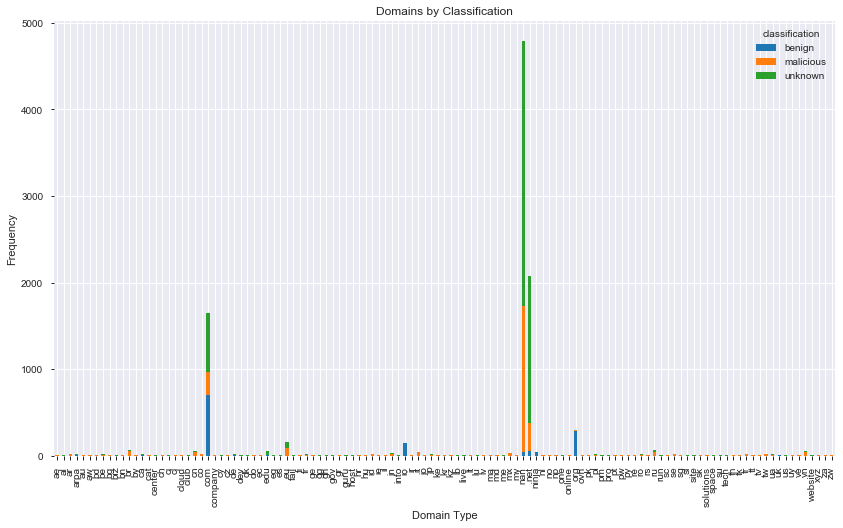

In [83]:
# Convert to pd series and add to df 

grey_noise_loc['domain_ends'] = pd.Series(domains_list) 

ax = grey_noise_loc.groupby(['domain_ends','classification']).size().unstack().plot(kind='bar',
                                                                                    stacked=True,
                                                                                   figsize=(14,8),
                                                                                   title="Domains by Classification")
ax.set_xlabel("Domain Type")
ax.set_ylabel("Frequency")
# plt.xticks(rotation=280)
plt.show()